## CarND Project 5 - Vehicle Tracking

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [16]:
# all necessary imports in one place
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import pickle

from classroom_functions import *

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

Found 8792 vehicles and 8968 non-vehicles


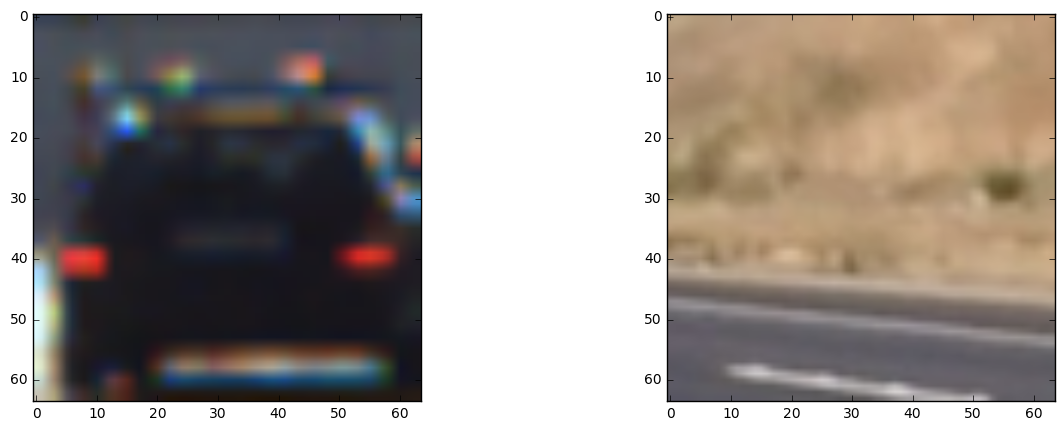

In [2]:
vs = glob.glob('data/vehicles/*/*.png')
nvs = glob.glob('data/non-vehicles/*/*.png')
print('Found {} vehicles and {} non-vehicles'.format(len(vs),len(nvs)))

v_ind = np.random.randint(0, len(vs))
nv_ind = np.random.randint(0, len(nvs))

v_image = mpimg.imread(vs[v_ind])
nv_image = mpimg.imread(nvs[nv_ind])
fig, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].imshow(v_image)
axarr[1].imshow(nv_image)

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

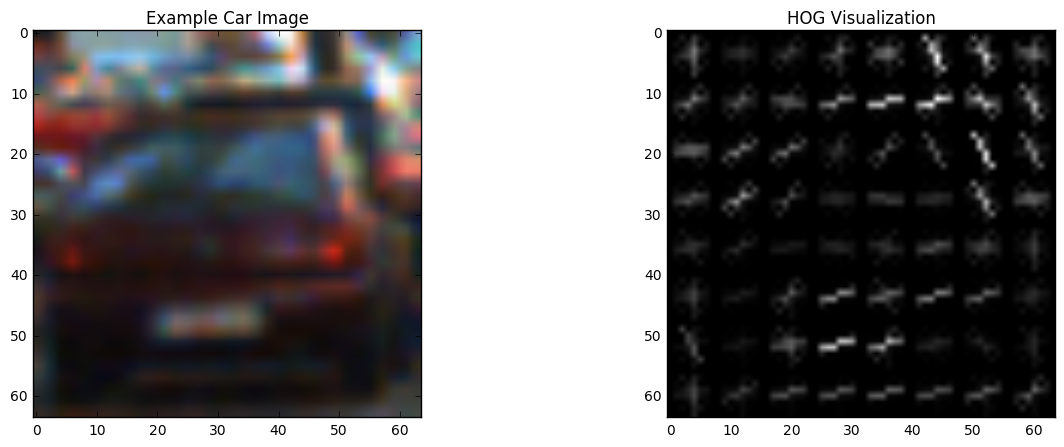

In [3]:
v_ind = np.random.randint(0, len(vs))
image = mpimg.imread(vs[v_ind])
ycryb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(ycryb[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### 2. Explain how you settled on your final choice of HOG parameters.

# TODO I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

# TODO I trained a linear SVM using...

In [4]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [5]:
sample_size = 500
vs = vs[0:sample_size]
nvs = nvs[0:sample_size]

In [6]:
t=time.time()
v_features = extract_features(vs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nv_features = extract_features(nvs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

1.31 Seconds to extract HOG features...


In [7]:
# Create an array stack of feature vectors
X = np.vstack((v_features, nv_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(v_features)), np.zeros(len(nv_features))))

In [8]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764


In [9]:
# Use a linear SVC 
# svc = LinearSVC()
# Use an SVC with a radial basis funciton kernel
svc = SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


0.74 Seconds to train SVC...


In [10]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.985
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  1.  1.  1.  1.]
0.00922 Seconds to predict 10 labels with SVC


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

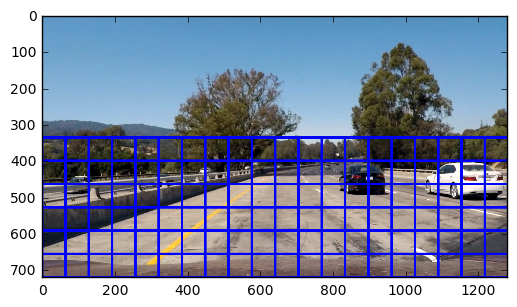

In [11]:
image = mpimg.imread('test_images/test1.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[720-6*64, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### My Processing Pipline

In [12]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [720-6*64, None] # Min and max in y to search in slide_window()

vs = glob.glob('data/vehicles/*/*.png')
nvs = glob.glob('data/non-vehicles/*/*.png')
print('Found {} vehicles and {} non-vehicles'.format(len(vs),len(nvs)))

t=time.time()
v_features = extract_features(vs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nv_features = extract_features(nvs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

Found 8792 vehicles and 8968 non-vehicles
64.66 Seconds to extract features...


In [20]:
X = np.vstack((v_features, nv_features))
X.astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(v_features)), np.zeros(len(nv_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# svc = LinearSVC()
# Use a SVC with a radial basis function kernel
svc = SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
310.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


In [22]:
# filename = 'svc_linear.p'
filename = 'svc_rbf.p'

In [23]:
# Save SVC to disk
with open(filename, 'wb') as file:
    pickle.dump(obj=svc, file=file)

In [18]:
# Load the camera calibration
with open(filename, "rb") as file:
    svc = pickle.load(file=file)

0.73 Seconds to predict single sample...


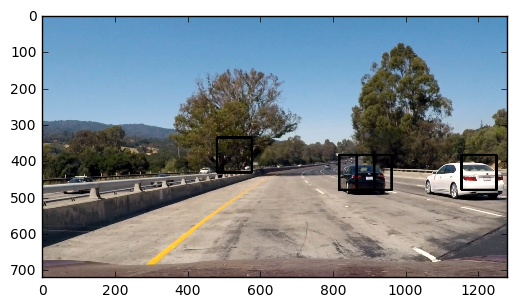

In [19]:
# Check the prediction time for a single sample
t=time.time()

# Careful, loading from .jpg
image = mpimg.imread('test_images/test1.jpg')
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
draw_image = np.copy(image)


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict single sample...')

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [45]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

3 cars found


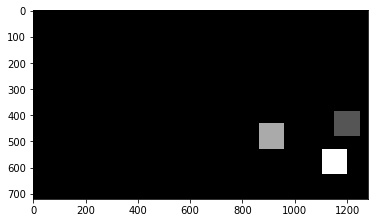

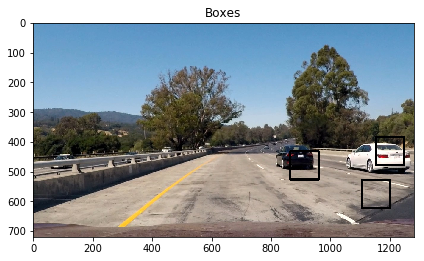

In [58]:
# # Careful, loading from .jpg
# image = mpimg.imread('test_images/test1.jpg')
# # Uncomment the following line if you extracted training
# # data from .png images (scaled 0 to 1 by mpimg) and the
# # image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

heatmap = np.zeros(image.shape[0:2])

# for idx, boxlist in enumerate(hot_windows):
add_heat(heatmap, hot_windows)
    
threshold = 0 #2
heatmap = apply_threshold(heatmap, threshold)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
    
heatmap = heatmap * 3
    
final_map = np.clip(heatmap - 2, 0, 255)


# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# Plot the examples
fig = plt.figure(figsize=(15,5))
plt.subplot(111)
plt.imshow(final_map, cmap='hot')
plt.title('Heatmap')
plt.subplot(121)
plt.imshow(draw_img, cmap='gray')
plt.title('Boxes')

In [40]:
heatmap = np.zeros(image.shape[0:2])
heatmap.shape


(720, 1280)

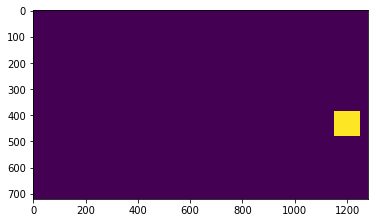

In [49]:
box = hot_windows[0]
heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
heatmap.shape
plt.imshow(heatmap)

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

In [ ]:
![alt text][image4]

---

### Video Implementation

In [61]:
def process_frame(image):
    
    return image

In [63]:
# video processing here
filename = 'test_video.mp4'
# filename = 'project_video.mp4'
output_filename = filename[:-4] + '_result.mp4'

clip = VideoFileClip(filename)
project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|█████████▋| 38/39 [00:00<00:00, 61.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

CPU times: user 118 ms, sys: 146 ms, total: 264 ms
Wall time: 2.55 s


#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

In [ ]:
![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

In [ ]:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:

In [ ]:
![alt text][image7]

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  